# Mass Produced Calculation

Batch time 100 hrs

In [1]:
import openmc
import openmc.deplete 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi
import xml.etree.ElementTree as et

In [2]:
# define materials

water = openmc.Material(name='water')
water.set_density('g/cc',0.989) # density of water at 320K (steady state operating temp of TRIGA)
water.add_element('H',2.0)
water.add_element('O',1.0)
water.add_s_alpha_beta('c_H_in_H2O')

pipe = openmc.Material(name = 'steel') # 304L Stainless steel from PNNL material Compendium
pipe.set_density('g/cc', 8.0)
pipe.add_element('C',0.000687)
pipe.add_element('Si',0.009793)
pipe.add_element('P',0.000408)
pipe.add_element('S',0.000257)
pipe.add_element('Cr',0.201015)
pipe.add_element('Mn',0.010013)
pipe.add_element('Fe',0.684101)
pipe.add_element('Ni',0.093725)


target = openmc.Material(name='target')
target.set_density('g/cc', 0.432)
target.add_nuclide('Np237', 1.0)
target.add_element('H', 1.0)
target.add_element('N', 1.0)
target.add_element('O', 3.0)

# add trace amount of Np238, Pu238, and Pu236 so depletion works...
target.add_nuclide('Np238',1e-18)
target.add_nuclide('Pu238',1e-18)
target.add_nuclide('Pu236',1e-18)

target.depletable = True

In [3]:
target_d = 5.0 # cm, diameter of target pin

pin_wall_thickness = 0.5 # cm

pitch = target_d + pin_wall_thickness + 10.0 # cm, lattice pitch.

height = 10.0 # cm, cell height

# define surfaces
# infinite prism along the z-axis, pitch x pitch square
cell_prism = openmc.model.rectangular_prism(pitch,pitch,
                                            boundary_type='vacuum')

cell_top = openmc.ZPlane(z0=height/2,boundary_type='reflective')
cell_bottom = openmc.ZPlane(z0=-height/2.,boundary_type='reflective')
clad_o = openmc.ZCylinder(r=(target_d+2.*pin_wall_thickness)/2.)
target_o = openmc.ZCylinder(r=target_d/2.)

# define regions
target_region = -target_o & -cell_top & +cell_bottom
clad_region = -clad_o & +target_o & -cell_top & +cell_bottom

# note the object cell_prism refers to the inside of the prism
mod_region = +clad_o & cell_prism & -cell_top & +cell_bottom

# define cells
target_c = openmc.Cell(name='target')
target_c.fill = target
target_c.region = target_region

clad_c = openmc.Cell(name='clad')
clad_c.fill = pipe
clad_c.region = clad_region

mod_c = openmc.Cell(name='mod')
mod_c.fill = water
mod_c.region = mod_region

# define the universe
root_univ = openmc.Universe()
root_univ.add_cells([target_c,clad_c,mod_c])

geometry = openmc.Geometry()
geometry.root_universe = root_univ
geometry.export_to_xml()

target.volume = np.pi*((target_d**2)/4.)*height;

materials = openmc.Materials([water,pipe,target])
materials.export_to_xml()

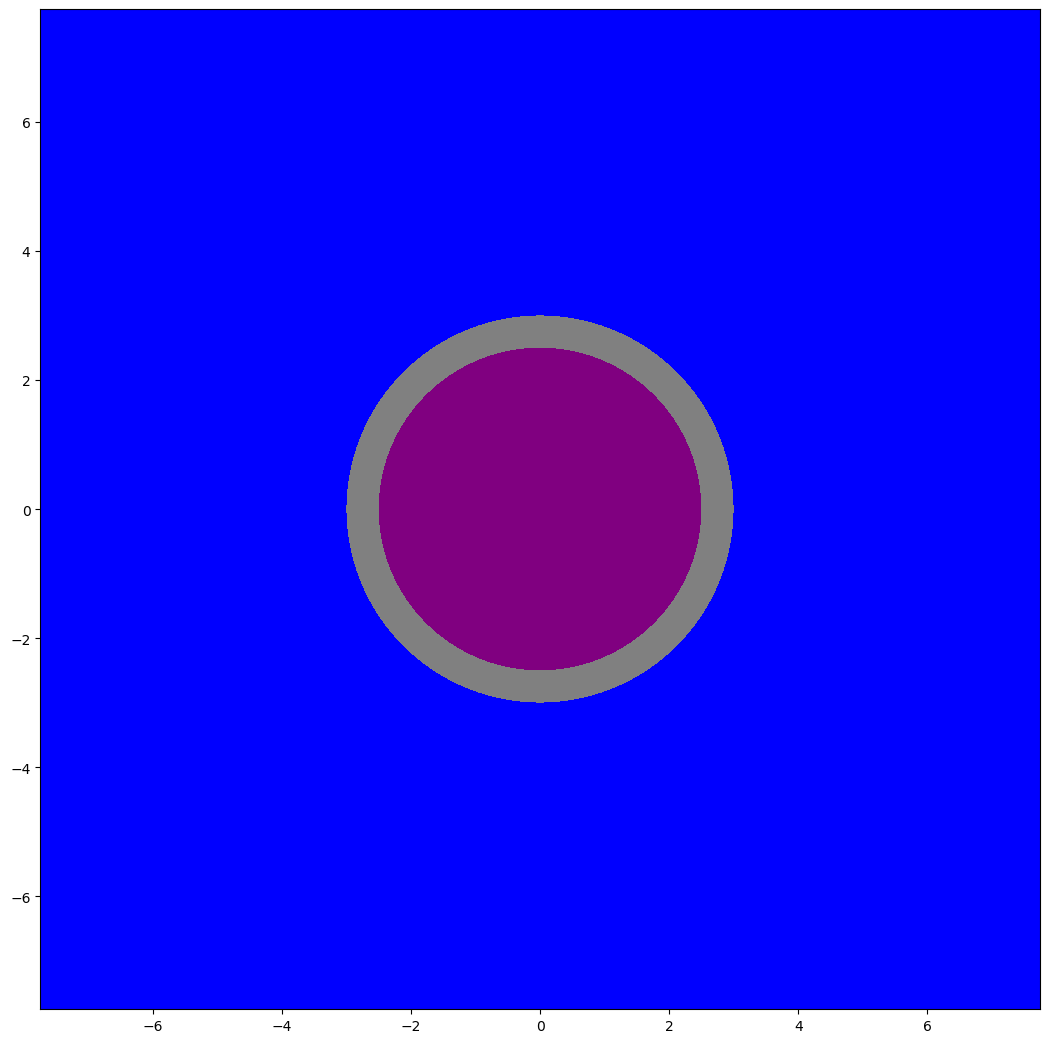

In [4]:
# plot root universe

colors = {}
colors[water]='blue'
colors[pipe]='gray'
colors[target]='purple'
root_univ.plot(origin=(0,0,0),width=(pitch,pitch),
               pixels=(1000,1000),color_by='material',
               basis='xy',colors=colors)

In [5]:
# define the source(s)


temp = 20 + 273.15; # in K
ev_K = 8.61732814974056E-05
f_maxwell = temp*ev_K # eV, 
#f_maxwell = 2.37e23; # eV

energy_sp = openmc.stats.Watt();

# spatial distribution of the 4 walls
# left wall: 
sp_left = openmc.stats.CartesianIndependent(x=openmc.stats.Discrete(-pitch/2.+1e-3,1),
                                           y=openmc.stats.Uniform(-pitch/2.,pitch/2.),
                                           z=openmc.stats.Uniform(-height/2.,height/2.));
#right wall:
#sp_right = openmc.stats.CartesianIndependent(x=openmc.stats.Discrete(pitch/2.-1e-3,1.0),
#                                           y=openmc.stats.Uniform(-pitch/2.,pitch/2.),
#                                           z=openmc.stats.Uniform(-height/2.,height/2.));

# "top" wall:
#sp_top = openmc.stats.CartesianIndependent(x=openmc.stats.Uniform(-pitch/2.,pitch/2.),
#                                           y=openmc.stats.Discrete(pitch/2.-1e-3,1.0),
#                                           z=openmc.stats.Uniform(-height/2.,height/2.));

# "bottom" wall:
#sp_bottom = openmc.stats.CartesianIndependent(x=openmc.stats.Uniform(-pitch/2.,pitch/2.),
#                                           y=openmc.stats.Discrete(-pitch/2.+1e-3,1),
#                                           z=openmc.stats.Uniform(-height/2.,height/2.));

s_left = openmc.Source(space=sp_left,
                      angle=openmc.stats.Monodirectional((1.0,0.0,0.0)),
                       energy=energy_sp) 

#s_right = openmc.Source(space=sp_right,
#                      angle=openmc.stats.Monodirectional((-1.0,0.0,0.0)),
#                       energy=energy_sp)
#
#s_top = openmc.Source(space=sp_top,
#                      angle=openmc.stats.Monodirectional((0.0,-1.0,0.0)),
#                       energy=energy_sp)

#s_bottom = openmc.Source(space=sp_bottom,
#                      angle=openmc.stats.Monodirectional((0.0,1.0,0.0)),
#                       energy=energy_sp)

In [6]:
# settings

settings = openmc.Settings() # create openmc settings object
#energy = openmc.stats.Watt() # create energy spectrum of particles
#settings.source = [s_left, s_right, s_top, s_bottom]
settings.source = [s_left]
settings.run_mode = 'fixed source'
settings.batches = 200
settings.inactive = 50
settings.particles = 300000
settings.generations_per_batch = 1

settings.export_to_xml()

In [7]:
model = openmc.model.Model(geometry,materials,settings)

operator = openmc.deplete.CoupledOperator(model,chain_file="chain_endfb71_pwr.xml",
                                         normalization_mode='source-rate');

# Assume a flux of 1e14 n/cm^2-s
avg_flux = 1.0e14; # n/cm^2-s
source_rate = height*pitch*avg_flux; # n/s
hours = 3600;
time_steps = [1000*hours];

cecm = openmc.deplete.PredictorIntegrator(operator,time_steps,
                                    source_rates=source_rate);


repeat_depletion = False;

if(repeat_depletion):
    cecm.integrate()

In [8]:
r = openmc.deplete.Results('./depletion_results.h5')
burned_materials = r.export_to_materials(burnup_index=1)
burned_materials.export_to_xml('BurnedMaterials1.xml')

In [9]:
mat_tree = et.parse('BurnedMaterials1.xml')
root = mat_tree.getroot()
i=0
for child in root:
    if child.attrib['name']=='target':
        target_elem = root[i]
    i+=1

In [10]:
# create Material object from element in burned Materials object
target_elem.set('id',23)
#print(target_elem.items())
#type(target_elem)
burned_target = openmc.Material.from_xml_element(target_elem)
burned_target_mass = burned_target.get_mass()

print(burned_target)
print(burned_target_mass, 'g')

Material
	ID             =	23
	Name           =	target
	Temperature    =	None
	Density        =	None [sum]
	Volume         =	196.34954084936209 [cm^3]
	S(a,b) Tables  
	Nuclides       
	Ac225          =	2.341515692873899e-22 [ao]
	Ac226          =	1.4971702339709355e-25 [ao]
	Ac227          =	9.382633474344706e-22 [ao]
	Ag107          =	6.36087024861489e-17 [ao]
	Ag109          =	4.442843461201052e-09 [ao]
	Ag110_m1       =	1.95405064192282e-12 [ao]
	Ag111          =	2.1087436447495258e-10 [ao]
	Al27           =	9.999843224747858e-22 [ao]
	Am240          =	7.391238182855534e-22 [ao]
	Am241          =	5.997112542532271e-14 [ao]
	Am242          =	8.372629205282567e-17 [ao]
	Am242_m1       =	5.4348688625847505e-17 [ao]
	Am243          =	7.483370387681237e-16 [ao]
	Am244          =	1.17306146222524e-20 [ao]
	Am244_m1       =	8.203713393844344e-21 [ao]
	Ar36           =	9.995553983239753e-22 [ao]
	Ar38           =	9.99969443437399e-22 [ao]
	Ar40           =	1.0002737968524201e-21 [ao]
	As74

In [11]:
listnuc = burned_target.get_nuclides()
import re
Puiso = []
for nuclide in listnuc:
    if re.search('Pu.+', nuclide):
        Puiso.append(nuclide)

In [12]:
pu_mass =0.
for nuclide in Puiso:
    pu_mass+=burned_target.get_mass(nuclide=nuclide)
print(pu_mass, 'g')

pu_mass_fraction = pu_mass/burned_target_mass
print(pu_mass_fraction, 'pu mass/target mass')

1.0104602004208836 g
0.011912036938569598 pu mass/target mass


In [13]:
# create metallic Pu from separated Pu product in Burned Fuel
SepPu = openmc.Material(name='PuProduct')
SepPu.set_density('g/cc',19.84) # density used for all metallic Plutonium in PNNL Compendium

print(Puiso)
i = len(Puiso)
n = 0
BurnPuAo = []
while (n < i):
    BurnPu = burned_target.get_nuclide_atom_densities(Puiso[n])
    BurnPuAo.append(BurnPu)
    SepPu.add_nuclide(Puiso[n],BurnPu[Puiso[n]])
    n+=1
#print(BurnPuAo)
#print(SepPu)

['Pu236', 'Pu237', 'Pu238', 'Pu239', 'Pu240', 'Pu241', 'Pu242', 'Pu243', 'Pu244', 'Pu246']


In [14]:
# calculate mass of Pu-238 produced
coil_length = 2908; # coil length (cm)
model_factor = coil_length/height # number of models to one coil length

Pu238_mass_model = burned_target.get_mass('Pu238') # mass of pu238 per model length
Pu238_mass_batch = Pu238_mass_model*model_factor # mass of pu238 per batch (g)
print('The mass of Pu-238 produced in one batch is',Pu238_mass_batch,'g')

SepPuAo = SepPu.get_nuclide_atom_densities()

Pu238assay = (SepPuAo['Pu238'])/(SepPuAo['Pu236'] + SepPuAo['Pu237'] + SepPuAo['Pu238'] 
                                 + SepPuAo['Pu239'] + SepPuAo['Pu240'] + SepPuAo['Pu241'] 
                                 + SepPuAo['Pu242'] + SepPuAo['Pu243'] + SepPuAo['Pu244'] 
                                 + SepPuAo['Pu246'])
print('The product Pu-238 assay is',Pu238assay*100,'%')

Pu28_29 = (SepPuAo['Pu238']/SepPuAo['Pu239'])
print('The ratio of Pu238/Pu239 is',Pu28_29)

The mass of Pu-238 produced in one batch is 289.6129310858871 g
The product Pu-238 assay is 98.56684734268326 %
The ratio of Pu238/Pu239 is 69.60093755391851
